In [19]:
import numpy as np
from math import pi
import sympy as sp
from scipy.stats import poisson
from itertools import product


def make_it_periodic(a=0, b=2*pi):
    return lambda f: lambda t: f((t - a) % (b - a) + a)

def c_coeff(f, T=2*pi, k=0, dt=0.0001):
    ts = np.arange(-T/2, T/2, dt)
    return 1/T * np.sum(f(ts) * np.exp(-2j * k * pi * ts / T) * dt)

def a_coeff(f, T=2*pi, k=0, dt=0.0001):
    if k == 0:
        return c_coeff(f, T=T, k=k, dt=dt)
    else:
        ck  = c_coeff(f, T=T, k=k,  dt=dt)
        c_k = c_coeff(f, T=T, k=-k, dt=dt)
        return (ck + c_k).real

def b_coeff(f, T=2*pi, k=0, dt=0.0001):
    if k == 0:
        raise ValueError("k must be greater than zero!")
    else:
        ck  = c_coeff(f, T=T, k=k,  dt=dt)
        c_k = c_coeff(f, T=T, k=-k, dt=dt)
        return (1j * (ck - c_k)).real

def complex_fourier(f, T=2*pi, N=10):
    ks = np.arange(-N, N+1)
    c_ks = [c_coeff(f, T=T, k=k) for k in ks]
    return lambda t: np.sum(c_ks * np.exp(2j * ks * pi * t / T)).real

def entropy(probabilities=(0, 1)):
    return (-np.log2(probabilities) * probabilities).sum()

def expected_value(values=(0, 1), probabilities=(0.5, 0.5)):
    return np.dot(values, probabilities)

def poisson_distribution(k=1, lam=2, dp=4, return_results=False):
    cdfk   = poisson.cdf(k,   mu=lam)
    cdfk_1 = poisson.cdf(k-1, mu=lam)
    print(f"P(X <= {k}) = {cdfk          :.{dp}f}")
    print(f"P(X <  {k}) = {cdfk_1        :.{dp}f}")
    print(f"P(X >= {k}) = {1 - cdfk_1    :.{dp}f}")
    print(f"P(X >  {k}) = {1 - cdfk      :.{dp}f}")
    print(f"P(X =  {k}) = {cdfk - cdfk_1 :.{dp}f}")
    if return_results:
        return cdfx, cdfx_1, 1-cdfx_1, 1-cdfx, cdfx-cdfx_1

def generate_entropy_equation(ps, geometric_distribution=False):
    result = "("
    for p in ps:
        _p_ = p
        if "1" in p and "-" in p and \
            not (p.startswith("(") and p.endswith(")")):
            _p_ = p
            p = "(" + p + ")"            
        result += f"-{p}*log({_p_})"
    result += ")/log(2)"
    if geometric_distribution:
        result = "(-(1-p)*log(1-p) - p*log(p)) / (p * log(2))"
    print(result)


def fourier_coefficient(f, letter="a", k=1, next_to=None, 
                            period_start="0", period_end="T"):
    f = sp.sympify(f)
    if next_to is not None:
        letter = "a" if "cos" in next_to else "b"
        next_to = next_to[3:].replace("T", "1")\
            .replace("pi", "1").replace("t", "1")
        k = int(eval(next_to)) // 2

    if letter.lower() == "a":
        if k == 0:
            trig = sp.sympify("1/T")
            coeff = sp.sympify(f"A_0")
        else:
            trig = sp.sympify(f"2/T * cos(2*pi*{k}*t/T)")
            coeff = sp.sympify(f"A_{k}")
    elif letter.lower() == "b":
        trig = sp.sympify(f"2/T * sin(2*pi*{k}*t/T)")
        coeff = sp.sympify(f"B_{k}")
    expr = sp.Mul(f, trig)
    integral = sp.Integral(expr, ("t", period_start, period_end))
    result = sp.integrate(expr, ("t", period_start, period_end))
    display(sp.Eq(coeff, sp.Eq(integral, result)))


def transmitantion(numerator="1", denominator="s"):
    for i, z in enumerate(sp.solve(sp.sympify(numerator))):
        display(sp.Eq(sp.Eq(sp.sympify(f"z_{i+1}"), z), z.evalf(), evaluate=False))

    for i, p in enumerate(sp.solve(sp.sympify(denominator))):
        display(sp.Eq(sp.Eq(sp.sympify(f"p_{i+1}"), p), p.evalf(), evaluate=False))


def signal_energy(signal, nonnegative_t=True):
    lower_limit = -sp.oo
    if nonnegative_t:
        lower_limit = 0
    symbol = sp.sympify("E_f")
    formula = sp.Integral(sp.sympify(f"abs((x(t))^2)"), ("t", lower_limit, sp.oo))
    result = sp.integrate(sp.sympify(f"abs(({signal})^2)"), ("t", lower_limit, sp.oo))
    display(sp.Eq(symbol, sp.Eq(formula, sp.Eq(result, result.evalf(), evaluate=False), evaluate=False)))


def filtration_info(ht, omega, A):
    s, t = sp.symbols('s, t')
    ht = sp.sympify(ht)
    laplace = sp.laplace_transform(ht, t, s, noconds=True, simplify=True)
    print("Przesunięcie fazowe:", sp.arg(laplace.subs(s, omega * 1j)))
    print("Nowa amplituda:",  A * sp.Abs(laplace.subs(s, omega * 1j)))

def n_balls_probability(urn: dict, balls_picked=1):
    picks = list(product(urn.keys(), repeat=balls_picked))
    number_of_balls = sum(urn.values())
    probabilities = []
    for pick in picks:
        P = 1
        _urn = urn.copy()
        _number_of_balls = number_of_balls
        for ball in pick:
            P *= _urn[ball] / (_number_of_balls)
            _urn[ball] -= 1
            _number_of_balls -= 1
        probabilities.append(P)
    return probabilities

# Spis treści:

1. Oszacowanie średniej liczby pytań o opcje
2. Średnia liczba wejść na Twoją nową stronę
3. Zmienne losowe $X$ i $Y$ przyjmują wartości ze zbioru $E$. Rozkład łączny...
4. Zmienna losowa $X$ przyjmuje wartości ze zbioru $E$ (...) Podaj wzór na entropię
5. Zmienna losowa $X$ ma rozkład geometryczny (...) Podaj wzór na entropię
6. Zmienna losowa $X \colon \Omega \to \{...\}$ ma rozkład dany wektorem (przykład bez wzoru na $Y$)
7. Zmienna losowa $X \colon \Omega \to \{...\}$ ma rozkład dany wektorem (...) (Y = X z jakimś modulo)
8. Podaj współczynnik $a_k$/$b_k$ w rozwinięciu w szereg Fouriera sygnału
9. Podaj współczynnik przy $\cos(\ldots)$ / $\sin(\ldots)$ w rozwinięciu w szereg Fouriera sygnału
10. Podaj zera i bieguny transmitancji zadanej formułą
11. Prawdopodobieństwo awarii serwera
12. Energia sygnału
13. Zmienna losowa ma rozkład Poissona
14. Sygnał $x$ został spróbkowany i poddany filtracji ze sprzężeniem zwrotnym
15. Dany niech będzie sygnał (...) Dokonujemy jego filtracji filtrem o odpowiedzi impulsowej
16. Podać transformatę okna czasowego
17. Z urny zawierającej ...
18. Ciąg -> transformata $Z$
19. Transformata $Z$ -> ciąg
20. Zdania prawdziwe / fałszywe



---
## 1. Oszacowanie średniej liczby pytań o opcje

In [20]:
# UWAGA: jeśli w zadaniu jest podane mniej prawdopodobieństw 
# niż możliwych opcji/zdarzeń (znane wartości prawdopodobieństw 
# z treści zadania nie sumują się do 1), to dopisujemy  jeszcze
# prawdopodobieństwo zdarzenia dopełniającego, np. jako 
# p5 = 1 - p1 - p2 - p3 - p4

p1 = 0.24
p2 = 0.25
p3 = 0.1
p4 = 1 - p1 - p2 - p3

HX = entropy(probabilities=(p1, p2, p3, p4))
print(f"Średnia liczba pytań jest nie mniejsza niż: {HX}")

# UWAGA: wartość oczekiwaną liczymy tylko z wartości o prawdopodobieństwach
# podanych w treści zadania (z jednego i drugiego podpunktu). 
# Jeśli dla jakiejś wartości zmiennej losowej nie podano nigdzie 
# prawdopodobieństwa, to tę wartość pomijamy...

EX = expected_value(values=(1, 2, 3, 4), probabilities=(p1, p2, p3, p4))
print(f"Eξ jest równa: {EX}")

Średnia liczba pytań jest nie mniejsza niż: 1.8537120107758156
Eξ jest równa: 2.68


---
## 2. Średnia liczba wejść na Twoją nową stronę

### (a)

In [21]:
lam = 2.7 # średnia liczba wejść na godzinę
k = 1     # liczba wejść na godzinę
dp = 4    # liczba miejsc po przecinku

poisson_distribution(k=k, lam=lam, dp=dp)

P(X <= 1) = 0.2487
P(X <  1) = 0.0672
P(X >= 1) = 0.9328
P(X >  1) = 0.7513
P(X =  1) = 0.1815


### (b)

In [22]:
lam = 2.7 # średnia liczba wejść na godzinę
k = 2     # liczba wejść na godzinę
dp = 4    # liczba miejsc po przecinku

poisson_distribution(k=k, lam=lam, dp=dp)

P(X <= 2) = 0.4936
P(X <  2) = 0.2487
P(X >= 2) = 0.7513
P(X >  2) = 0.5064
P(X =  2) = 0.2450


---
## 3. Zmienne losowe $X$ i $Y$ przyjmują wartości ze zbioru $E$. Rozkład łączny...

In [23]:

P = np.array(
    [   # Y=1,  Y=2,  Y=3
        [0.09, 0.13, 0.07], # X = 1
        [0.07, 0.12, 0.16], # X = 2
        [0.09, 0.11, 0.16]  # X = 3
    ]
)

X = 3
Y = 1

PXiY = P[X-1, Y-1]
PY = P[:, Y-1].sum() 
PX = P[X-1, :].sum()
PX_Y = PXiY / PY
PY_X = PXiY / PX

print(f"P(X = {X} | Y = {Y}) = {PX_Y}")
print(f"P(Y = {Y} | X = {X}) = {PY_X}")



P(X = 3 | Y = 1) = 0.36
P(Y = 1 | X = 3) = 0.25


---
## 4. Zmienna losowa $X$ przyjmuje wartości ze zbioru $E$ (...) Podaj wzór na entropię

Wzór na entropię $X$ to $$H(X) = -\sum_{i=1}^np_i\log_2(p_i) = -\sum_{i=1}^np_i\frac{\log(p_i)}{\log(2)}$$
$$= \frac{-p_1\log{p_1} - p_2\log{p_2} - \ldots - p_n\log{p_n}}{\log{2}}$$


In [24]:
# UWAGA: jeśli w zadaniu jest podane mniej prawdopodobieństw 
# niż możliwych opcji/zdarzeń, np. mamy 
# E = {1, 2, 3, 4} i P(X = i) = pi dla i = 1, 2, 3
# to należy przyjąć p4 = 1 - p1 - p2 - p3.

E = {1, 2, 3, 4}

ps = (
    "p1",
    "p2",
    "p3",
    "1-p1-p2-p3",
    )

generate_entropy_equation(ps)

(-p1*log(p1)-p2*log(p2)-p3*log(p3)-(1-p1-p2-p3)*log(1-p1-p2-p3))/log(2)


---
## 5. Zmienna losowa $X$ ma rozkład geometryczny (...) Podaj wzór na entropię

In [25]:
# UWAGA: jeśli w zadaniu pojawi się rozkład inny niż geometryczny, 
# to zawsze można posiłkować się wikipedią (uwaga na podstawę logarytmu,
# być może wynik z wikipedii będzie trzeba podzielić przez log(2)).

generate_entropy_equation(("p", ("1-p")), geometric_distribution=True)

(-(1-p)*log(1-p) - p*log(p)) / (p * log(2))


---
## 6. Zmienna losowa $X \colon \Omega \to \{...\}$ ma rozkład dany wektorem (przykład bez wzoru na $Y$)

$$H(X) = -\sum_{i=1}^np_X(x_i)\log_2{\left(p_X(x_i)\right)}$$

$$H(X | Y = y) = -\sum_{i=1}^np(x_i)\log_2{\left(p(x_i)\right)}$$

UWAGA: $H(X, Y)$ i $I(X; Y)$ wychodzą inaczej niż w odpowiedziach... Nie wiem co jest nie tak, podejrzewam, że treść zadania. 

In [26]:
X = np.array([1, 2, 3, 4]) # Wartości X
P_X = np.array([0.1, 0.1, 0.01, 0.79]) # Prawdopodobieństwa X

# Liczymy i wpisujemy prawdopodobieństwa warunkowe. 
# Konwencja nazewnictwa zmiennych: P(X = x | Y = y) = P_xIy

# =============================================== P(X = i | Y = 1)
P_1I1 = P_X[0] / (P_X[0] + P_X[1]) # P(X = 1 | Y = 1)
P_2I1 = 1 - P_1I1                  # P(X = 2 | Y = 1)
P_3I1 = 0                          # P(X = 3 | Y = 1)
P_4I1 = 0                          # P(X = 4 | Y = 1)

# =============================================== P(X = i | Y = 2)
P_1I2 = 0                          # P(X = 1 | Y = 2)
P_2I2 = P_X[1] / (P_X[1] + P_X[2]) # P(X = 2 | Y = 2)
P_3I2 = 1 - P_2I2                  # P(X = 3 | Y = 2)
P_4I2 = 0                          # P(X = 4 | Y = 2)

# =============================================== P(X = i | Y = 3)
P_1I3 = 0                          # P(X = 1 | Y = 3)
P_2I3 = 0                          # P(X = 2 | Y = 3)
P_3I3 = P_X[2] / (P_X[2] + P_X[3]) # P(X = 3 | Y = 3)
P_4I3 = 1 - P_3I3                  # P(X = 4 | Y = 3)

###########################################################


In [27]:
P_XI1 = np.array((P_1I1, P_2I1, P_3I1, P_4I1)) # P(X | Y = 1)
P_XI2 = np.array((P_1I2, P_2I2, P_3I2, P_4I2)) # P(X | Y = 2)
P_XI3 = np.array((P_1I3, P_2I3, P_3I3, P_4I3)) # P(X | Y = 3)


H_X = entropy(P_X)
H_XI1 = entropy(P_XI1[P_XI1 != 0])
H_XI2 = entropy(P_XI2[P_XI2 != 0])
H_XI3 = entropy(P_XI3[P_XI3 != 0])

P_Y1 = P_X[0] / P_1I1 # P(X=1) = P(X=1 | Y=1)P(Y=1)
P_Y3 = P_X[3] / P_4I3 # P(X=4) = P(X=4 | Y=3)P(Y=3)

P_Y = np.array((P_Y1, 1-(P_Y1 + P_Y3), P_Y3))
H_Y = entropy(P_Y[P_Y != 0])
H_XIY = np.dot(P_Y, np.array((H_XI1, H_XI2, H_XI3)))
H_YIX = H_XIY - H_X + H_Y
I_XY = H_X - H_XIY
print(f"H(X) = {H_X}")
print(f"H(X | Y = 1) = {H_XI1}")
print(f"H(X | Y = 2) = {H_XI2}")
print(f"H(X | Y = 3) = {H_XI3}")
print(f"H(X | Y) = {H_XIY}")
print(f"H(Y | X) = {H_YIX}")
print(f"I(X; Y) = {I_XY}")

H(X) = 0.9994837797373408
H(X | Y = 1) = 1.0
H(X | Y = 2) = 0.43949698692151307
H(X | Y = 3) = 0.09694460606247315
H(X | Y) = 0.27755568484997856
H(Y | X) = 0.0
I(X; Y) = 0.7219280948873623


---
## 7. Zmienna losowa $X \colon \Omega \to \{...\}$ ma rozkład dany wektorem (...) (Y = X z jakimś modulo)

In [28]:
P_X = np.array([0.25, 0.02, 0.01, 0.72]) # Prawdopodobieństwa X
P_Y = np.array([P_X[1] + P_X[3], P_X[0] + P_X[2]]) # Prawdopodobieństwa Y

# Liczymy i wpisujemy prawdopodobieństwa warunkowe. 
# Konwencja nazewnictwa zmiennych: P(X = x | Y = y) = P_xIy

# ====================================================== P(X = i | Y = 0)
P_1I0 = 0                          # P(X = 1 | Y = 0)
P_2I0 = P_X[1] / (P_X[1] + P_X[3]) # P(X = 2 | Y = 0)
P_3I0 = 0                          # P(X = 3 | Y = 0)
P_4I0 = 1 - P_2I0                  # P(X = 4 | Y = 0)

# ====================================================== P(X = i | Y = 1)
P_1I1 = P_X[0] / (P_X[0] + P_X[2]) # P(X = 1 | Y = 1)
P_2I1 = 0                          # P(X = 2 | Y = 1)
P_3I1 = 1 - P_1I1                  # P(X = 3 | Y = 1)
P_4I1 = 0                          # P(X = 4 | Y = 1)

P_XI0 = np.array([P_1I0, P_2I0, P_3I0, P_4I0])
P_XI1 = np.array([P_1I1, P_2I1, P_3I1, P_4I1])

###########################################################
H_X = entropy(P_X)
H_XI0 = entropy(P_XI0[P_XI0 != 0])
H_XI1 = entropy(P_XI1[P_XI1 != 0])
H_XIY = np.dot([H_XI0, H_XI1], P_Y)

print(f"P(Y = 1) = {P_Y[1]}")
print(f"H(X) = {H_X}")
print(f"H(X | Y = 0) = {H_XI0}")
print(f"H(X | Y = 1) = {H_XI1}")
print(f"H(X | Y) = {H_XIY}")
print(f"I(X; Y) = {H_X - H_XIY}")

P(Y = 1) = 0.26
H(X) = 1.0205461412925787
H(X | Y = 0) = 0.1792560669283215
H(X | Y = 1) = 0.23519338181924188
H(X | Y) = 0.1937997687999608
I(X; Y) = 0.8267463724926178


---
## 8. Podaj współczynnik $a_k$/$b_k$ w rozwinięciu w szereg Fouriera sygnału

In [29]:
signal = "0.125 * sin(4 * pi * t / T)" # signal function

fourier_coefficient(signal, 
                    k=2, 
                    letter="b", 
                    period_start="0", 
                    period_end="T")

Eq(B_2, Eq(Integral(0.25*sin(4*pi*t/T)**2/T, (t, 0, T)), Piecewise((0.125, (T > -oo) & (T < oo) & Ne(T, 0)), (0, True))))

---
## 9. Podaj współczynnik przy $\cos(\ldots)$ / $\sin(\ldots)$ w rozwinięciu w szereg Fouriera sygnału

In [30]:
signal = "4/T * (t - T/2) + 2" # signal function
next_to = "sin(20 * pi * t / T)"

fourier_coefficient(signal, 
                    next_to=next_to, 
                    period_start="-T/2", 
                    period_end="T/2")

Eq(B_10, Eq(Integral(2*(2 + 4*(-T/2 + t)/T)*sin(20*pi*t/T)/T, (t, -T/2, T/2)), -2/(5*pi)))

---
## 10. Podaj zera i bieguny transmitancji zadanej formułą

In [31]:
H_licznik = "s + 1"
H_mianownik = "s^2 + 5"

transmitantion(numerator=H_licznik, denominator=H_mianownik)

Eq(Eq(z_1, -1), -1.0)

Eq(Eq(p_1, -sqrt(5)*I), -2.23606797749979*I)

Eq(Eq(p_2, sqrt(5)*I), 2.23606797749979*I)

---
## 11. Prawdopodobieństwo awarii serwera

In [32]:
error_probability = 0.02
per_days = 100
lam = error_probability*per_days

k = 2
poisson_distribution(k=k, lam=lam)

P(X <= 2) = 0.6767
P(X <  2) = 0.4060
P(X >= 2) = 0.5940
P(X >  2) = 0.3233
P(X =  2) = 0.2707


---
## 12. Energia sygnału

In [33]:
signal = "32 / (1 + 7*t)^4"
signal_energy(signal, nonnegative_t=True)

Eq(E_f, Eq(Integral(Abs(x(t)**2), (t, 0, oo)), Eq(1024/49, 20.8979591836735)))

---
## 13. Zmienna losowa ma rozkład Poissona

In [34]:
lam = 2.5
k = 3

poisson_distribution(lam=lam, k=k)

P(X <= 3) = 0.7576
P(X <  3) = 0.5438
P(X >= 3) = 0.4562
P(X >  3) = 0.2424
P(X =  3) = 0.2138


---
## 14. Sygnał $x$ został spróbkowany i poddany filtracji ze sprzężeniem zwrotnym

Jeśli w indeksach dolnych wyrazów ciągu w równaniu rekurencyjnym znajdują się jakieś minusy, to należy najpierw przeindeksować to równanie, tak by było prawdziwe dla $n \geqslant 0$. Przykładowo

$$x_n = -4x_{n-1} + 7x_{n-2}$$

zmieniamy na

$$x_{n+2} = -4x_{n+1} + 7x_{n}$$

Zmienione równanie wrzucamy do wolframa:

<a href="https://www.wolframalpha.com/input?i=Z-transform+x%28n%2B2%29+%3D+-4+*+x%28n%2B1%29+%2B+7+*+x%28n%29">https://www.wolframalpha.com/input?i=Z-transform+x%28n%2B2%29+%3D+-4+*+x%28n%2B1%29+%2B+7+*+x%28n%29</a>

Wynikowe równanie roziązujemy (na kartce) ze względu na $Z_n\left[x(z)\right](z)$. Wynik to szukane $F(z)$.

---
## 15. Dany niech będzie sygnał (...) Dokonujemy jego filtracji filtrem o odpowiedzi impulsowej

In [35]:
# initial signal x(t) = A * sin(omega * t)
xt = "3 * sin(17*t)"
omega = 17
A = 3

# filter (impulse response)
ht = "exp(-5*t)"

filtration_info(ht, omega, A)

Przesunięcie fazowe: -1.28474488507758
Nowa amplituda: 0.169299794394930


---
## 16. Podać transformatę okna czasowego

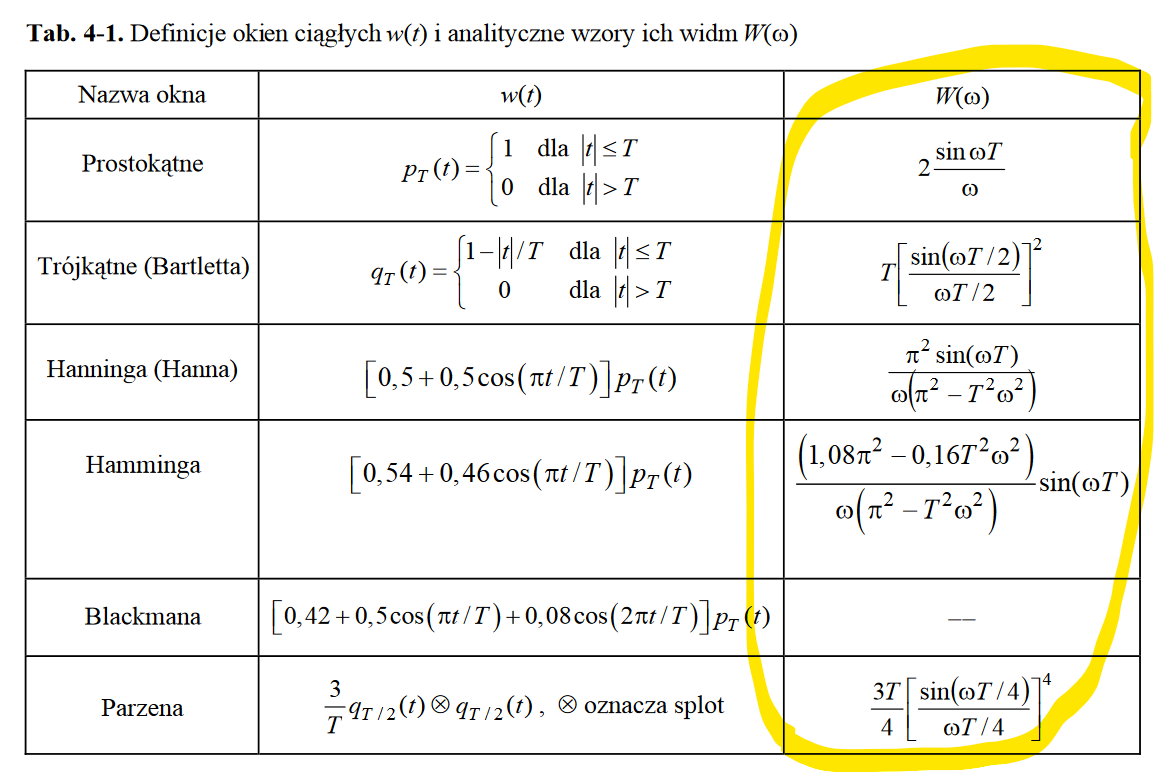

---
## 17. Z urny zawierającej ...

In [36]:
URNA = {
    "a": 24, # liczba kul amarantowych
    "b": 23, # liczba kul białych
    "c": 57, # liczba kul czerwonych
}

ile_kul_wybrano = 2

#########################################################
nP = n_balls_probability(URNA, ile_kul_wybrano)
P = n_balls_probability(URNA)
print("Informacja z określenia koloru: ", entropy(nP))

Informacja z określenia koloru:  2.8900550107937883


In [37]:
x = 0.9
# Obserwator może rozpoznać kolor za 1. lub za 2. razem
# Przykład:

# P(rozpoznał amarantowy) = P(amarantowy)*P(rozpoznał właściwie) + 
#                           P(biały)*P(nie rozpoznał właściwie)*P(rozpoznał z pozostałych | wcześniej się pomylił) +
#                           P(czerwony)*P(nie rozpoznał właściwie)*P(rozpoznał z pozostałych | wcześniej się pomylił) +

P_Ya = P[0]*x + P[1]*(1-x)*0.5 + P[2]*(1-x)*0.5 # P(rozpoznał amarantowy) 
P_Yb = P[1]*x + P[0]*(1-x)*0.5 + P[2]*(1-x)*0.5 # P(rozpoznał biały) 
P_Yc = P[2]*x + P[1]*(1-x)*0.5 + P[0]*(1-x)*0.5 # P(rozpoznał czerwony) 

print("Rozpoznaje AMARANTOWY z prawdopodobieństwem: ", P_Ya)
print("Rozpoznaje BIAŁY z prawdopodobieństwem: ", P_Yb)
print("Rozpoznaje CZERWONY z prawdopodobieństwem: ", P_Yc)
print("Entropia po stronie obserwatora: ", entropy((P_Ya, P_Yb, P_Yc)))

Rozpoznaje AMARANTOWY z prawdopodobieństwem:  0.24615384615384614
Rozpoznaje BIAŁY z prawdopodobieństwem:  0.2379807692307692
Rozpoznaje CZERWONY z prawdopodobieństwem:  0.5158653846153847
Entropia po stronie obserwatora:  1.4833086769705703


In [38]:
# to be continued...

---
## 18. Ciąg -> transformata $Z$

https://www.wolframalpha.com/input?i=Z-transform+calculator&assumption=%7B%22F%22%2C+%22ZTransformCalculator%22%2C+%22transformfunction%22%7D+-%3E%228%5En+*+Heaviside%28n%29%22&assumption=%7B%22F%22%2C+%22ZTransformCalculator%22%2C+%22variable1%22%7D+-%3E%22n%22&assumption=%7B%22F%22%2C+%22ZTransformCalculator%22%2C+%22variable2%22%7D+-%3E%22z%22

---
## 19. Transformata $Z$ -> ciąg

https://www.wolframalpha.com/input?i=inverse+Z+transform+calculator

(wynikowe równanie najpewniej będzie trzeba nieco uporządkować)

---
## 20. Zdania prawdziwe / fałszywe



* <span style="color:lime">Transformacja Fouriera zachowuje energię sygnału ✓</span>
---
* <span style="color:lime">FILTROWANIE sygnału to z punktu widzenia matematyka MNOŻENIE widm sygnałów ✓</span>
* <span style="color:red">FILTROWANIE sygnału to z punktu widzenia matematyka SPLOT widm sygnałów ✗</span>
* <span style="color:red">MODULACJA sygnału to z punktu widzenia matematyka MNOŻENIE widm sygnałów ✗</span>
---
* <span style="color:lime">Szereg Fouriera pozwala rozłożyć funkcję OKRESOWĄ spełniającą warunki Dirichleta na sumę funkcji trygonometrycznych ✓</span>
* <span style="color:red">Szereg Fouriera pozwala rozłożyć KAŻDĄ funkcję spełniającą warunki Dirichleta na sumę funkcji trygonometrycznych ✗</span>
---
* <span style="color:red">Modulacja RZECZYWISTA sygnału poprzez wymnożenie go przez sygnał o amplitudzie jednostkowej powoduje przesunięcie w częstotliwości widma sygnału zmodulowanego o pewną fazę ✗</span>
* <span style="color:lime">Modulacja ZESPOLONA sygnału poprzez wymnożenie go przez sygnał o amplitudzie jednostkowej powoduje przesunięcie w częstotliwości widma sygnału zmodulowanego o pewną fazę ✓</span>
---
* <span style="color:lime">Rozszerzenie pasma widma sygnału powoduje jego SZYBSZY przebieg w dziedzinie czasu ✓</span>
* <span style="color:red">Rozszerzenie pasma widma sygnału powoduje jego WOLNIEJSZY przebieg w dziedzinie czasu ✗</span>
---
* <span style="color:lime">Przy projektowaniu filtrów metodą "zer i biegunów", każdy biegun transmitancji powoduje ZMNIEJSZENIE nachylenia charakterystyki amplitudowej o 20 decybeli na dekadę ✓</span>
* <span style="color:red">Przy projektowaniu filtrów metodą "zer i biegunów", każdy biegun transmitancji powoduje ZWIĘKSZENIE nachylenia charakterystyki amplitudowej o 20 decybeli na dekadę ✗</span>
* <span style="color:lime">Przy projektowaniu filtrów metodą "zer i biegunów", każde zero transmitancji powoduje ZWIĘKSZENIE nachylenia charakterystyki amplitudowej o 20 decybeli na dekadę ✓</span>
* <span style="color:red">Przy projektowaniu filtrów metodą "zer i biegunów", każde zero transmitancji powoduje ZMNIEJSZENIE nachylenia charakterystyki amplitudowej o 20 decybeli na dekadę ✗</span>
---
* <span style="color:red">Znając tylko widmo częstotliwościowe sygnału nie jesteśmy w stanie obliczyć energii sygnału ✗</span>

* <span style="color:lime">Skalowanie wartości sygnału przez stałą większą niż 1 powoduje rozszerzanie wartości widma częstotliwościowego ✓</span>
* <span style="color:red">Widmem dystrybucji (delty Diraca) jest skok jednostkowy ✗</span>
* <span style="color:red">Częstotliwość mierzymy w sekundach ✗</span>
* <span style="color:red">Charakterystyka amplitudowo-częstotliwościowa jest funkcją zespoloną z niezerową częścią urojoną ✗</span>
* <span style="color:lime">Wykresy Bodego są przedstawieniem charakterystyki amplitudowo-częstotliwościowej, w której oś pulsacji przedstawiona jest w skali logarytmicznej ✓</span>
* <span style="color:lime">Układy LTI przetwarzają sygnały wykorzystując sygnał zwany odpowiedzią impulsową, a operacja ta jest nazywana splotem dwóch sygnałów, czyli filtrowaniem ✓</span>
* <span style="color:lime">Modulację sygnału stosuje się w celu UŁATWIENIA nadawania czy odbierania sygnału i ZWIĘKSZENIA odporności na zakłócenia ✓</span>
* <span style="color:red">W wyniku przesunięcia fazowego sygnału rzeczywistego zawsze uzyskuje się sygnał rzeczywisty ✗</span>
